In [1]:
# import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import gseapy as gp
import plotly.graph_objects as go
import plotly.express as px
from translate import Translator
import time

In [2]:
# set working directory
work_dir = '/home/project/organoids'
repo_dir = f'{work_dir}/project_labubu'
data_dir = f'{work_dir}/transfered_from_galaxy'
results_path = f'{repo_dir}/results/dge_gsea'
# create results directory if does not exist
os.makedirs(results_path,exist_ok=True)

In [48]:
# fill dataset metadata
# add dataset number and name
dat_met = {'SRP561920':{'name':'Retina','name_ukr':'Ретина'},
        'ERP142256':{'name':'CRC tumoroid','name_ukr':'Колоректальний рак'},
          'ERP111852':{'name':'Lung bud tip','name_ukr':'Кінчик легеневої бруньки'}}
# add paths to samples list and deseq2 results
samples_file = f'{repo_dir}/data/?/SRR_Acc_List.txt'
samples_organoid_file = f'{repo_dir}/data/?/SRR_Acc_List-organoid.txt'
deseq2_file = f'{data_dir}/?/deseq2/deseq2_result'
dge_gsea_dir = f'{results_path}/?'
for dataset in dat_met:
    dat_met[dataset]['samples_file']=samples_file.replace('?',dataset)
    dat_met[dataset]['samples_organoid_file']=samples_organoid_file.replace('?',dataset)
    dat_met[dataset]['deseq2_file']=deseq2_file.replace('?',dataset)
    dat_met[dataset]['dge_gsea_dir']=dge_gsea_dir.replace('?',dataset)
    # create datasets subfolders in results directory if do not exist
    os.makedirs(f'{results_path}/{dataset}',exist_ok=True)

In [22]:
# import statistical test results: organoid -vs- tissue
colnames = ['GeneID',	'Base mean',	'log2(FC)',	'StdErr',	'Wald-Stats',	'P-value',	'P-adj']
# stuck results in one table
deseq2_data = []
for dataset in dat_met:
    deseq2_results_path = dat_met[dataset]['deseq2_file']
    df = pd.read_csv(deseq2_results_path, sep='\t', names = colnames)
    df['dataset'] = dataset
    deseq2_data.append(df)
deseq2_data = pd.concat(deseq2_data, ignore_index=True)

In [23]:
# filter genes by Base Mean - remove low counts genes
deseq2_data=deseq2_data[deseq2_data['Base mean']>10]

In [118]:
# create function that visualises deseq2 results in volcano plot
def dge_volcano_plot(data, save_dir, title=None, fc_thresh = 2, pval_thresh = 0.01, plot=True):
    """
    Input:
        data - deseq2 result for one dataset
        save_dir - directory where save the plot
        title - plot name (optional)
        fc_thresh - Log2(Fold Change) threshold (default 2)
        pval_thresh - p-value threshold (default 0.01)
    """
    # Set significance threshold
    sig_thresh = -np.log10(pval_thresh)
    # Define colors
    data['color'] = 'grey'
    data.loc[(data['log2(FC)'] > fc_thresh) & (data['P-adj'] < pval_thresh), 'color'] = 'red'
    data.loc[(data['log2(FC)'] < -fc_thresh) & (data['P-adj'] < pval_thresh), 'color'] = 'blue'
    # Transform p-value
    data['-log10(P-adj)'] = -np.log(data['P-adj'])
    print(f"Upregulated: {round((len(data[data.color=='red'])/len(data))*100,2)}; Downregulated: {round((len(data[data.color=='blue'])/len(data))*100,2)}")
    # Plot
    if plot:
        plt.figure(figsize=(4,6))
        plt.scatter(data['log2(FC)'], data['-log10(P-adj)'], c=data['color'], alpha=0.7)
        # Threshold lines
        plt.axvline(fc_thresh, color='black', linestyle='--')
        plt.axvline(-fc_thresh, color='black', linestyle='--')
        plt.axhline(sig_thresh, color='black', linestyle='--')
        # Axis annotation
        if title: plt.title(title, size=15)
        #plt.xlabel('log2 Fold Change')
        #plt.ylabel('-log10 p-value adjusted')
        plt.xlabel('Зміна експресії (log2 Fold Change)',size=12)
        plt.ylabel('Скоригована значущість (-log10 p-value adjusted)',size=12)
        plt.savefig(f"{save_dir}/volcanoplot.svg", format="svg", bbox_inches ='tight' )
        plt.savefig(f"{save_dir}/volcanoplot.png", format="png", bbox_inches ='tight' )
        plt.show()

In [120]:
# do volcano plot for each dataset
for dataset, data in deseq2_data.groupby('dataset'):
    save_dir = dat_met[dataset]['dge_gsea_dir']
    title_ukr = f"{dat_met[dataset]['name_ukr']}"
    print(dataset)
    dge_volcano_plot(data, save_dir, title_ukr, plot=False)

ERP111852
Upregulated: 5.45; Downregulated: 11.08
ERP142256
Upregulated: 1.1; Downregulated: 14.76
SRP561920
Upregulated: 24.9; Downregulated: 21.64


/home/project/organoids/conda_envs/organoids/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/project/organoids/conda_envs/organoids/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
# create function to do GSEA analysis
def gsea_dotplot(data, save_dir, title=None, export=True, gene_sets='KEGG_2021_Human', organism='Human', fdr = 0.25, top_n = 5):
    """
    Input:
        data - deseq2 result for one dataset
        save_dir - directory where save the plot
        title - plot name (optional)
        export - return GSEA result
        gene_sets - catalog of gene sets (default KEGG_2021_Human)
        organism - (defult Human)
        fdr - corrected p-value threshold (default 0.25)
        top_n - number of terms to select from head and tail of NES-sorted results
    """
    # rank genes
    rnk = data.sort_values('log2(FC)', ascending=False)[["GeneID", 'log2(FC)']]
    # GSEA
    gsea_results = gp.prerank(
        rnk=rnk,
        gene_sets=gene_sets,
        organism=organism,
        permutation_num=1000,
        seed=42,
        verbose=True
    )
    # convert into table
    res = gsea_results.res2d
    # select
    res = res[res["FDR q-val"] < fdr]
    res["FDR q-val"] = res["FDR q-val"].replace(0, 1e-300)
    res = res.sort_values("NES")
    res = pd.concat([res.head(top_n), res.tail(top_n)])
    # save
    res.to_csv(f'{save_dir}/{gene_sets}_res.tsv',sep='\t')
    # plot gene sets
    #ax = gp.dotplot(res,
    #               column="FDR q-val",
    #                cmap=plt.cm.viridis,
    #                 size=6, # adjust dot size
    #                 figsize=(4,5), cutoff = fdr, show_ring=False)
    #ax.set_xlabel('normalized enrichment score')
    #if title: ax.set_title(title)
    #plt.savefig(f"{save_dir}/{gene_sets}_dotplot.svg", format="svg", bbox_inches ='tight' )
    #plt.show()
    #plt.close()
    if export: return gsea_results

In [ ]:
# do GSEA and dot plot for each dataset
for dataset, data in deseq2_data.groupby('dataset'):
    save_dir = dat_met[dataset]['dge_gsea_dir']
    title = f"{dat_met[dataset]['name']}"
    # Pathways
    gsea_dotplot(data, save_dir, title, export=False)
    # Cell type
    gsea_dotplot(data, save_dir, title, export=False, gene_sets='PanglaoDB_Augmented_2021')

In [105]:
# Translate dotplot axes and labels
# set up automatic translation from English to Ukrainian
translator = Translator(to_lang="uk",email='132.butylka.75@gmail.com')
# set adjusted p-value threshold
fdr = 0.25
# List files prefixes (GSEA libraries)
libs = ['KEGG_2021_Human','PanglaoDB_Augmented_2021']
x_label=translator.translate('normalized enrichment score')
legend_title=translator.translate('% Genes in set')
for dataset in dat_met:
    save_dir = dat_met[dataset]['dge_gsea_dir']
    for lib in libs:
        # retreave title in Ukrainian
        title_ukr = dat_met[dataset]['name_ukr']
        # load annotation data
        df = pd.read_csv(f'{results_path}/{dataset}/{lib}_res.tsv',sep='\t')
        ax = gp.dotplot(
                        df,
                        column="FDR q-val",
                        cutoff=1.0,
                        top_term=df.shape[0],
                        show_ring=False,
                    )
        ax.set_xlabel(x_label)
        ax.set_title(title_ukr, size=15)
        ax.get_legend().set_title(legend_title)
        # translate
        terms_eng = [tick.get_text() for tick in ax.get_yticklabels()]
        terms_ukr = [translator.translate(term) for term in terms_eng]
        ax.set_yticklabels(terms_ukr)
        plt.savefig(f"{save_dir}/{lib}_dotplot_ukr.svg", format="svg", bbox_inches ='tight' )
        plt.savefig(f"{save_dir}/{lib}_dotplot_ukr.png", format="png", bbox_inches ='tight' )
        #plt.show()
        plt.close()
        print(f'Plot for {dataset} {lib} is done.')

/tmp/ipykernel_545098/3016154152.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(terms_ukr)


Plot for SRP561920 KEGG_2021_Human is done.


/tmp/ipykernel_545098/3016154152.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(terms_ukr)


Plot for SRP561920 PanglaoDB_Augmented_2021 is done.


/tmp/ipykernel_545098/3016154152.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(terms_ukr)


Plot for ERP142256 KEGG_2021_Human is done.


/tmp/ipykernel_545098/3016154152.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(terms_ukr)


Plot for ERP142256 PanglaoDB_Augmented_2021 is done.


/tmp/ipykernel_545098/3016154152.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(terms_ukr)


Plot for ERP111852 KEGG_2021_Human is done.


/tmp/ipykernel_545098/3016154152.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(terms_ukr)


Plot for ERP111852 PanglaoDB_Augmented_2021 is done.


In [ ]:
# Plot top n genes of GSEA pathways on Volcano Plot

In [125]:
def dge_volcano_plot(
    data,
    save_dir,
    title=None,
    fc_thresh=2,
    pval_thresh=0.01,
    pathway_genes=None,
):
    import matplotlib.pyplot as plt
    import numpy as np

    data = data.copy()

    # Threshold
    sig_thresh = -np.log10(pval_thresh)

    # Base colors
    data["color"] = "lightgrey"
    data.loc[
        (data["log2(FC)"] > fc_thresh) & (data["P-adj"] < pval_thresh),
        "color",
    ] = "red"
    data.loc[
        (data["log2(FC)"] < -fc_thresh) & (data["P-adj"] < pval_thresh),
        "color",
    ] = "blue"

    # Transform p-values
    data["-log10(P-adj)"] = -np.log10(data["P-adj"])

    # Base plot
    plt.figure(figsize=(4, 6))
    plt.scatter(
        data["log2(FC)"],
        data["-log10(P-adj)"],
        c=data["color"],
        alpha=0.1,
        s=10,
    )

    # Threshold lines
    plt.axvline(fc_thresh, color="black", linestyle="--")
    plt.axvline(-fc_thresh, color="black", linestyle="--")
    plt.axhline(sig_thresh, color="black", linestyle="--")

    sns.despine()

    # === HIGHLIGHT PATHWAY GENES ===
    if pathway_genes:
        colors = plt.cm.tab10(np.linspace(0, 1, len(pathway_genes)))
        pathway_colors = dict(zip(pathway_genes.keys(), colors))

        for pathway, genes in pathway_genes.items():
            sub = data[data["GeneID"].isin(genes)]

            plt.scatter(
                sub["log2(FC)"],
                sub["-log10(P-adj)"],
                color=pathway_colors[pathway],
                s=30,
                edgecolor="none",
                label=pathway,
                zorder=3,
            )

            # Annotate genes
            for _, row in sub.iterrows():
                plt.text(
                    row["log2(FC)"],
                    row["-log10(P-adj)"],
                    row["GeneID"],
                    fontsize=8,
                    ha="left",
                    va="bottom",
                )

        plt.legend(fontsize=8, frameon=False, bbox_to_anchor=(1,1))

    # Labels
    if title:
        plt.title(title, size=15)

    plt.xlabel("Зміна експресії (log2 Fold Change)", size=12)
    plt.ylabel("Скоригована значущість (-log10 p-value adjusted)", size=12)

    #plt.savefig(
    #    f"{save_dir}/volcanoplot.svg",
    #    format="svg",
    #    bbox_inches="tight",
    #)
    plt.show()


/home/project/organoids/conda_envs/organoids/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


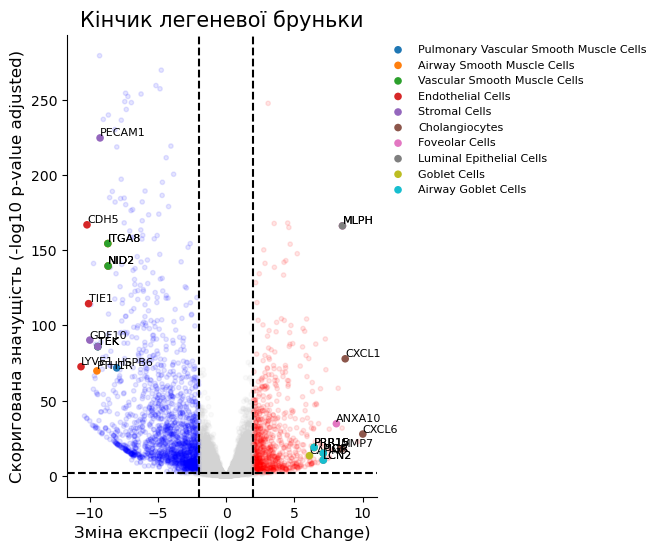

In [148]:
top_n = 3
dataset = 'ERP111852'
lib = 'PanglaoDB_Augmented_2021' #'KEGG_2021_Human'
pathway_genes = {}
deseq_df = deseq2_data[(deseq2_data['dataset']==dataset)]
gsea_df = pd.read_csv(f'{results_path}/{dataset}/{lib}_res.tsv',sep='\t')

for i, row in gsea_df.iterrows():
    term = row['Term']
    down = row['NES'] < 0
    pathway_lead_genes = row['Lead_genes'].split(';')
    path_top_genes = deseq_df[(deseq_df['GeneID'].isin(pathway_lead_genes))].sort_values('log2(FC)', ascending=down ).head(top_n)['GeneID'].tolist()
    pathway_genes.update({term : path_top_genes})

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

colors = plt.cm.tab10(np.linspace(0, 1, len(pathway_genes)))
pathway_colors = dict(zip(pathway_genes.keys(), colors))

title = dat_met[dataset]['name_ukr']
dge_volcano_plot(
    data=deseq_df,
    save_dir=None,
    title=title,
    pathway_genes=pathway_genes,
)

/home/project/organoids/conda_envs/organoids/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


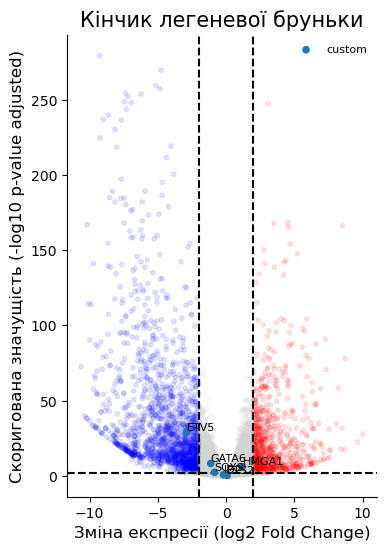

In [153]:
genes = ["ETV5", "ETS2", "SOX9", "GATA6", "HMGA1", "ID2"]
dge_volcano_plot(
    data=deseq_df,
    save_dir=None,
    title=title,
    pathway_genes={'custom':genes},
)

In [154]:
deseq_df[deseq_df.GeneID.isin(genes)]

,GeneID,Base mean,log2(FC),StdErr,Wald-Stats,P-value,P-adj,dataset
92267,ETV5,2566.324898,-2.905852,0.251864,-11.537392,8.547790e-31,1.863466e-29,ERP111852
95607,GATA6,1156.226556,-1.125591,0.185850,-6.056460,1.391499e-09,7.375922e-09,ERP111852
96839,HMGA1,3422.614501,1.197617,0.232281,5.155894,2.524242e-07,1.046007e-06,ERP111852
101219,SOX9,1522.947465,-0.847371,0.277501,-3.053578,2.261298e-03,5.276438e-03,ERP111852
106886,ID2,2243.478494,-0.191696,0.134518,-1.425062,1.541393e-01,2.297748e-01,ERP111852
111811,ETS2,2592.762034,0.075802,0.152861,0.495884,6.199759e-01,7.034233e-01,ERP111852


In [9]:
# GSEA plot
#res = gsea_kegg.res2d.copy()
#res_sig = res[res["FDR q-val"] < 0.25]
#top_up = (
#    res_sig[res_sig["NES"] > 0]
#    .sort_values("NES", ascending=False)
#    .head(5)
#)
#top_down = (
#    res_sig[res_sig["NES"] < 0]
#    .sort_values("NES", ascending=True)
#    .head(5)
#)
#terms = list(top_down.Term) + list(top_up.Term)
#axs = gsea_kegg.plot(
#    terms=terms,
#    show_ranking=True,
#    figsize=(3, 4)
#)
